In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras.datasets import imdb

from deepthink.layers import EmbeddingLayer, GlobalAveragePoolingLayer, Dense, Dropout
from deepthink.model import Model
from deepthink.optimizers import Adam
from deepthink.loss import BinaryCrossEntropy
from deepthink.activations import Sigmoid
from deepthink.utils import pad_sequences

## IMDB Sentiment Analysis

The purpose of this notebook is to demonstrate text-classification using [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis). This example is inspired by [this](https://www.tensorflow.org/tutorials/keras/text_classification) TensorFlow tutorial.

#### IMDB Dataset

The dataset used is the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/), which consists of 50,000 movie reviews from [imdb.com](https://www.imdb.com/) split into 25,000 for training and 25,000 for testing. Each review is classed as positive or negative and the goal is to predict this from the review text. Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers).

In [23]:
import time

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from deepthink.metrics import (mean_squared_error,
                               root_mean_squared_error,
                               mean_absolute_error,
                               accuracy,
                               binary_accuracy)


class History:
    """
    A class to record model training history.

    Initialized when Model.train is called, this class records the
    model's performance after each epoch on train and validation
    predictions. It will store the model's loss/cost automatically,
    other metrics can be added using Model's 'metrics' argument.

    The metrics are stored in a dictionary, 'history', where the
    keys are the metrics and values are arrays recording performance
    at each epoch. This is similar to Kera's History.history.

    Training history can be visualized by calling 'plot_history'
    once training has been completed.

    Parameters
    ----------
    metrics : list
        A list of the metrics to use, created during model
        initialization. This should always contain the model's
        cost/loss as first element. Other metrics are optional
        and must be keys of the 'metric_dict' class attribute.
    verbose : bool,default=True
        Controls verbosity mode. If True a summary will be printed
        each epoch, if set to False nothing is printed.
    n_epochs : int,default=None
        The number of training epochs, used for displaying updates.
        This is a required argument when verbose is set to True.

    Attributes
    ----------
    metric_dict : dict
        A dictionary which maps strings to metric loss function.
    """

    metric_dict = {
        'accuracy': accuracy,
        'binary_accuracy': binary_accuracy,
        'RMSE': root_mean_squared_error,
        'MAE': mean_absolute_error,
        'MSE': mean_squared_error,
        }

    def __init__(self, metrics, verbose=True, n_epochs=None):
        self.metrics = metrics
        self.verbose = verbose
        self.n_epochs = n_epochs

        if self.verbose:
            # Store training time for displaying updates
            self.start_time = time.time()

        self.history = {}
        # Add 'loss' as default first metric
        self.history['loss'] = []
        self.history['val_loss'] = []
        for metric in self.metrics[1:]:
            # Add other optional metrics
            self.history[metric] = []
            self.history[f'val_{metric}'] = []

    def on_epoch_end(self, y_train, train_preds, y_val, val_preds):
        """
        This method calculates the current performance on all metrics
        and stores them in the history dictionary. When verbose is set
        to True an update is printed on screen.

        Parameters
        ----------
        y_train : np.array
            The y-target training values
        train_preds : np.array
            The model's training predictions
        y_val : np.array
            The y-target validation values
        train_preds : np.array
            The model's validation predictions
        """
        # Get and store the model's loss/cost function
        train_loss = self.metrics[0](y_train, train_preds)
        val_loss = self.metrics[0](y_val, val_preds)
        self.history['loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)

        for metric in self.metrics[1:]:
            # Get train & validation value for each metric
            train_value = self.metric_dict[metric](y_train, train_preds)
            val_value = self.metric_dict[metric](y_val, val_preds)
            self.history[metric].append(train_value)
            self.history[f'val_{metric}'].append(val_value)

        if self.verbose:
            # Add epoch progress and elapsed time to row variable
            elapsed_time = time.time() - self.start_time
            current_epoch = len(self.history['loss'])
            row = f"Epoch: {current_epoch}/{self.n_epochs}, " + \
                  f"elapsed-time: {elapsed_time:.2f}s - "

            # Add training cost/loss and all other metrics to row
            row += f"loss: {self.history['loss'][-1]:.4f} - "
            for metric in self.metrics[1:]:
                last_value = self.history[metric][-1]
                row += f"{metric}: {last_value:.4f} - "
            # Add validation loss and metrics to row
            row += f"val_loss: {self.history['val_loss'][-1]:.4f} - "
            for metric in self.metrics[1:]:
                last_value = self.history['val_' + metric][-1]
                row += f"val_{metric}: {last_value:.4f} - "
            # Display row
            print(row)

    def plot_history(self, display_image=True, save_fname=None):
        """
        Display model training performance at each epoch.

        Plots model cost/loss per epoch on training and validation.
        If any additional metrics are added then it will plot loss
        and one other metric.

        Parameters
        ----------
        display_image : book,default=True
            Boolean parameter to control whether the images is shown
            or not
        save_fname : str,default=None
            Optional argument to save the image, if used it should be
            the filename to save the image as.
        """
        # Set figure-size depending on number of metrics
        if len(self.metrics) == 1:
            fig, axes = plt.subplots(1, figsize=(14, 8))
            # Need to be able to index into axes
            axes = [axes]
        else:
            fig, axes = plt.subplots(2, figsize=(14, 12))

        x_labels = list(range(len(self.history['loss'])))
        x_ticks = [i for i in range(len(self.history['loss']))]

        # Plot the model's loss performance
        axes[0].plot(self.history['loss'], label='Train loss')
        axes[0].plot(self.history['val_loss'], label='Val loss')
        axes[0].set_ylabel('Loss', fontsize='x-large')
        axes[0].legend(fontsize='large', framealpha=1, fancybox=True)
        axes[0].set_xticks(ticks=x_ticks, labels=x_labels)
        # MaxNLocator used to dynamically set xtick locations
        axes[0].xaxis.set_major_locator(MaxNLocator(20))

        if len(self.metrics) > 1:
            # Plot additional metric if included
            metric = self.metrics[1]
            axes[1].plot(self.history[metric], label=f'Train {metric}')
            axes[1].plot(self.history[f'val_{metric}'], label=f'Val {metric}')
            axes[1].set_ylabel(metric, fontsize='x-large')
            axes[1].legend(fontsize='large', framealpha=1, fancybox=True)
            axes[1].set_xticks(ticks=x_ticks, labels=x_labels)
            axes[1].xaxis.set_major_locator(MaxNLocator(20))

        plt.xlabel('Epoch', fontsize='large')
        plt.legend(fontsize='large', framealpha=1, fancybox=True)
        if save_fname:
            plt.savefig(save_fname)
        if display_image:
            plt.show()


In [11]:
# Define the parameters
max_features = 10000  # Maximum vocab size
seq_len = 200  # Maximum length of each review
embedding_dim = 16
batch_size = 32
epochs = 10
learning_rate = 0.001

In [13]:
# Load the data
(train_text, train_labels), (X_test, y_test) = imdb.load_data(num_words=max_features)

# Reshape labels to column vector
train_labels = train_labels.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(train_text.shape, train_labels.shape)
print(X_test.shape, y_test.shape)

(25000,) (25000, 1)
(25000,) (25000, 1)


In [14]:
# View a sample review
sample = np.random.choice(train_text)
# Get the word index for each word in the review
word_to_idx = imdb.get_word_index()
# Create a reverse word index
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# Convert the review to text
review = ' '.join([idx_to_word.get(idx - 3, '?') for idx in sample])
print(review)

? anyone who is a sucker for 1920s jazz 1920s dress the ? and ultra ? ? e g me on all counts will want to like this movie but the sad fact is that that's all there is the plot is banal and obvious the acting mostly either awful or playing to the ? side of the goings on and when the whole ? over there is not much left but the impression of mirrors and smoke this is a beautifully made bad movie


In [16]:
# Pad the sequences
train_text = pad_sequences(train_text, seq_len)
X_test = pad_sequences(X_test, seq_len)

In [17]:
# Shuffle the data and split into training and validation sets
# (20k training, 5k validation as per the TensorFlow tutorial)
train_size = 20000
random_perm = np.random.permutation(train_text.shape[0])
train_text = train_text[random_perm]
train_labels = train_labels[random_perm]

X_train = train_text[:train_size]
y_train = train_labels[:train_size]
X_valid = train_text[train_size:]
y_valid = train_labels[train_size:]

In [25]:
# Define the model
opt = Adam(learning_rate=learning_rate)
model = Model(opt, cost=BinaryCrossEntropy(),
              batch_size=batch_size,
              metrics=['binary_accuracy'])

model.add_layer(EmbeddingLayer(max_features, embedding_dim,
                               input_shape=(batch_size, seq_len)))
model.add_layer(GlobalAveragePoolingLayer())
model.add_layer(Dense(1))
model.add_layer(Sigmoid())

model.initialize()

In [26]:
model.summary()

Model summary:
_________________________________________________________________
Layer Type                 Output Shape                   Param #
Embedding Layer           (None, 16, 200)                  160000
GlobalAveragePooling      (None, 16)                            0
Dense Layer               (None, 1)                            17
Sigmoid Activation        (None, 1)                             0
Total params: 160,017


In [27]:
# notebook version of tqdm used to display progress correctly in Jupyter
from tqdm.notebook import tqdm

In [28]:
history = model.train((X_train, y_train),
                      validation_data=(X_valid, y_valid),
                      epochs=epochs)

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 1/10, elapsed-time: 8.25s - loss: 0.5807 - accuracy_binary: 0.7789 - val_loss: 0.5874 - val_accuracy_binary: 0.7768 - 


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 2/10, elapsed-time: 16.55s - loss: 0.5121 - accuracy_binary: 0.8133 - val_loss: 0.4623 - val_accuracy_binary: 0.8291 - 


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 3/10, elapsed-time: 24.73s - loss: 0.4080 - accuracy_binary: 0.8538 - val_loss: 0.3929 - val_accuracy_binary: 0.8492 - 


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 4/10, elapsed-time: 32.64s - loss: 0.3479 - accuracy_binary: 0.8730 - val_loss: 0.3534 - val_accuracy_binary: 0.8570 - 


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 5/10, elapsed-time: 40.94s - loss: 0.3096 - accuracy_binary: 0.8848 - val_loss: 0.3332 - val_accuracy_binary: 0.8586 - 


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 6/10, elapsed-time: 48.81s - loss: 0.2819 - accuracy_binary: 0.8964 - val_loss: 0.3165 - val_accuracy_binary: 0.8698 - 


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 7/10, elapsed-time: 56.81s - loss: 0.2596 - accuracy_binary: 0.9042 - val_loss: 0.3069 - val_accuracy_binary: 0.8744 - 


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 8/10, elapsed-time: 64.72s - loss: 0.2409 - accuracy_binary: 0.9122 - val_loss: 0.3054 - val_accuracy_binary: 0.8718 - 


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 9/10, elapsed-time: 72.84s - loss: 0.2250 - accuracy_binary: 0.9175 - val_loss: 0.2982 - val_accuracy_binary: 0.8790 - 


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 10/10, elapsed-time: 80.91s - loss: 0.2109 - accuracy_binary: 0.9235 - val_loss: 0.2971 - val_accuracy_binary: 0.8774 - 


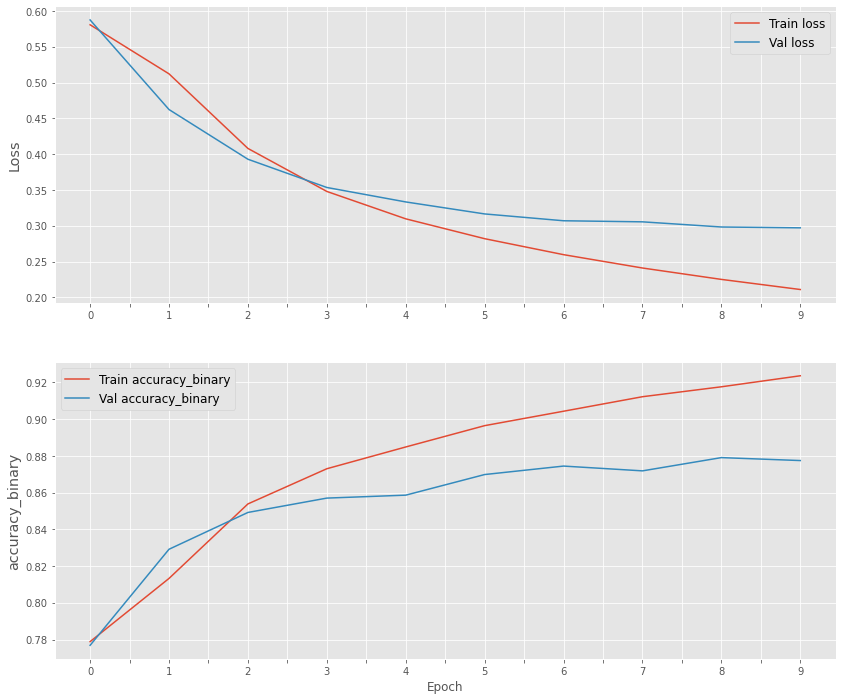

In [29]:
# Plot training history
plt.style.use('ggplot')

history.plot_history()

In [30]:
# Evaluate on test data
test_preds = model.get_predictions(X_test)
test_labels = y_test[:test_preds.shape[0]]
test_loss = BinaryCrossEntropy()(test_labels, test_preds)
binary_preds = np.round(test_preds)
test_acc = np.mean(binary_preds == test_labels)


print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2%}')


Test Loss: 0.3230
Test Accuracy: 86.28%
